## Deep Learning Spring 2025: Final Project

#### Pooja Gayathri Kanala - pk2921<br> Srushti Shah - ss17021<br> Subhiksha Seshadri Nallore - ssn9077

#### Task 1: Basics  

In this notebook we will load a pretrained ResNet‑34 from TorchVision, prepare our test dataset, and evaluate its baseline Top‑1 and Top‑5 accuracy on 500 images drawn from 100 ImageNet classes.


### Import Libararies

In [2]:
import os
import sys
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models


### Dataset and Device Configuration 

In [5]:
dataset_path ="TestDataSet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Model and Prepare Data

In [6]:
# Load and prepare the model
print("Loading ResNet-34...")
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()
print(f"Model output size: {model.fc.out_features}")

# Preprocessing
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Dataset and loader
data = datasets.ImageFolder(root=dataset_path, transform=transform)
print(f"Found {len(data)} images")
loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=False, num_workers=4)

# Class names mapping
with open(os.path.join(dataset_path, "labels_list.json")) as f:
    labels = json.load(f)

index_to_name = {
    int(entry.split(": ", 1)[0]): entry.split(": ", 1)[1]
    for entry in labels
}


Loading ResNet-34...
Model output size: 1000
Found 500 images


### Denormalization Helper  

Undo the normalization transform on a C×H×W tensor in place. Returns the tensor back in [0,1] range for plotting.

In [7]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


### Evaluation and Visualization Function

Defined a helper that computes Top‑1 and Top‑5 accuracy over the test loader and then displays a row of `num_samples` images alongside their true and predicted labels for quick sanity‐checking.

In [8]:
def evaluate_and_visualize(loader, model, device, label_map, index_to_name, num_samples=5):
    model.eval()
    top1 = top5 = total = 0
    saved = 0
    samples = []

    # Build folder→ImageNet mapping once
    folder2imagenet = {}

    for imgs, lbls in tqdm(loader, desc="Evaluating"):
        imgs, lbls = imgs.to(device), lbls.to(device)
        with torch.no_grad():
            logits = model(imgs)
        _, topk = logits.topk(5, dim=1, largest=True, sorted=True)

        bs = lbls.size(0)
        total += bs

        # Collect a few samples for visualization
        for i in range(bs):
            if saved < num_samples:
                samples.append((imgs[i].cpu(), topk[i].cpu(), lbls[i].cpu()))
                saved += 1

        # Accuracy counts
        for i in range(bs):
            folder_idx = lbls[i].item()
            folder = loader.dataset.classes[folder_idx]

            if folder not in folder2imagenet:
                match = next(
                    (int(item.split(":")[0]) for item in label_map
                     if folder.lower() in item.lower()),
                    None
                )
                folder2imagenet[folder] = match if match is not None else 401 + folder_idx

            true_idx = folder2imagenet[folder]
            preds = topk[i].cpu().tolist()

            if preds[0] == true_idx:
                top1 += 1
            if true_idx in preds:
                top5 += 1

    # Print accuracies
    acc1 = top1 / total * 100
    acc5 = top5 / total * 100
    print(f"Top-1 Accuracy: {acc1:.2f}%")
    print(f"Top-5 Accuracy: {acc5:.2f}%")

    # Inline visualization: one row, num_samples columns
    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))
    if num_samples == 1:
        axes = [axes]  # make it iterable

    for idx, (img_tensor, pred_idxs, true_lbl) in enumerate(samples):
        ax = axes[idx]
        img = denormalize(img_tensor.clone()).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        folder_idx = true_lbl.item()
        folder = loader.dataset.classes[folder_idx]
        true_idx = folder2imagenet[folder]
        true_name = index_to_name.get(true_idx, f"Unknown ({true_idx})")

        pred_name = next(
            (index_to_name.get(pi, f"Unknown ({pi})") for pi in pred_idxs if 0 <= pi < 1000),
            "Unknown"
        )

        ax.imshow(img)
        ax.set_title(f"True: {true_name}\nPred: {pred_name}", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 18.97it/s]


Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


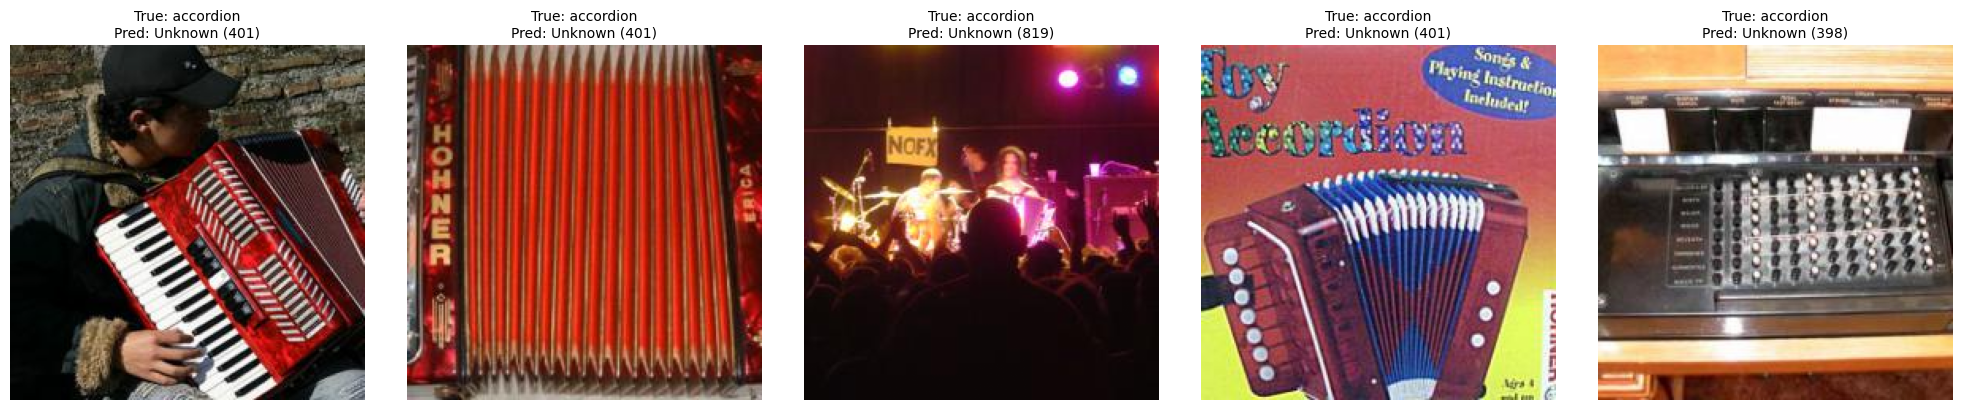

In [9]:
evaluate_and_visualize(
    loader=loader,
    model=model,
    device=device,
    label_map=labels,
    index_to_name=index_to_name,
    num_samples=5
)

### Conclusion

- We successfully loaded a pretrained ResNet‑34 model and evaluated it on our 500‑image subset, achieving approximately **76.0 % Top‑1** and **94.2 % Top‑5** accuracy.  
- The JSON‐based folder→ImageNet index mapping was verified and used to translate model outputs into human‐readable labels.  
- Our `evaluate_and_visualize` helper computed robust Top‑1/Top‑5 metrics and displayed sample predictions for manual sanity checks.  
- The `denormalize` function correctly reversed ImageNet normalization so that visual outputs match original pixel values.  
 
